# Jupyter Notebook that trains various ML models to detect bugs in code and then evaluates and compares their performance

# Global Imports

In [52]:
import pandas as pd
import sklearn
import re
import ast
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

# Helper Functions that Induce Bugs

In [53]:
# removes the first instance of the outermost parentheses in a line
# if possible
# eg: removeOuterParentheses('print (x + y)') = 'print x + y'
# removeOuterParentheses('(x / y) + (z * a)') = 'x / y + (z * a)'
def removeOuterParentheses(S: str) -> str:
    COUNT = 0
    START = 0
    RES = ''
    STARTED = False
    END = 0
    for i in range(len(S)):
        
        if (S[i] == '('):
            COUNT += 1
            if STARTED == False:
                START = i
                RES += S[:i]
                STARTED = True
            
        elif (S[i] == ')'): 
            COUNT -= 1
        
        if ((COUNT == 0) and (STARTED == True)):                
            RES += S[START+1 : i]
            RES += S[i+1:]
            break
            # START += i+1
            # END = i
    if ((RES == S) or (RES == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, RES, 'Missing_Outermost_Parenthesis')


# swaps a comparison operator (if present) in a line with the opposite comparison
# i.e. < becomes >, >= becomes <=. == is changed to = 
def swapComparison(S: str) -> str:
    swapped = ''
    if '<' in S:
        swapped = S.replace('<', '>')
    elif '>' in S:
        swapped = S.replace('>', '<')
    elif '<=' in S:
        swapped = S.replace('<=', '>=')
    elif '>=' in S:
        swapped = S.replace('>=', '<=')
    elif '==' in S:
        swapped = S.replace('==', '=')
    # if RES == S - return false
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Incorrect_Comparison')

# swaps a comparison operator (if present) in a line with a comparison operator
# that will create an off by one error. eg: <= becomes <
def offByOne(S: str) -> str:
    swapped = ''
    if '<' in S:
        swapped = S.replace('<', '<=')
    elif '>' in S:
        swapped = S.replace('>', '>=')
    elif '<=' in S:
        swapped = S.replace('<=', '<')
    elif '>=' in S:
        swapped = S.replace('>=', '>')
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Off_by_One')

# increases the indent of a line by one space
def increaseIndent(S: str) -> str:
    swapped = ' ' + S
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Extra_Indentation')

# decreases the indent of a line (if possible) by one space
def decreaseIndent(S: str) -> str:
    swapped = ''
    if S[0] == ' ':
        swapped = S[1:]
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Less_Indentation')
    
# increases the argument count of a function call - excluding print() and function definitions
# such that the first argument is added again at the end (if possible)
def increaseArgCount(S: str) -> str:
    new_string = ''
    if ('def' not in S) and ('print' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            index_end = S.find(')')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_end] + ', ' + S[index_start+1:index_comma] + S[index_end:]
            else:
                new_string = S[0:index_end] + ', ' + S[index_start+1:]
        elif ('[' in S) and (']' in S):
            index_start = S.find('[')
            index_end = S.find(']')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_end] + ', ' + S[index_start+1:index_comma] + S[index_end:]
            else:
                new_string = S[0:index_end] + ', ' + S[index_start+1:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Extra_Argument')

# decreases the argument count of a function call - excluding print() and function definitions
# such that the last argument is no longer present (if possible)
def decreaseArgCount(S: str) -> str:
    new_string = ''
    if ('def' not in S) and ('print' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            index_end = S.find(')')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_start+1] + S[index_comma+1:]
            else:
                new_string = S[0:index_start+1] + S[index_end:]
        elif ('[' in S) and (']' in S):
            index_start = S.find('[')
            index_end = S.find(']')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_start+1] + S[index_comma+1:]
            else:
                new_string = S[0:index_start+1] + S[index_end:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Less_Arguments')

# removes a function call (if possible) leaving just the variables present with a tuple
def removeFunctionCall(S: str) -> str:
    new_string = ''
    if ('def' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            temp_string = S[:index_start]
            flip_temp_string = temp_string[::-1]
            length_function_call = flip_temp_string.find(' ')
            if (length_function_call == 0):
                temp_string = S[:index_start - 1]
                flip_temp_string = temp_string[::-1]
                length_function_call = flip_temp_string.find(' ')
            # what if someone puts a space between function call and foo (x+y) - have to account for this
            if (length_function_call != -1):
                new_string = S[:index_start-length_function_call] + S[index_start:]
            else:
                new_string = S[index_start:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Missing_Function_Call')


# swaps the first two arguments of a function call (if possible)
# excluding function definitions
def swapArguments(S: str) -> str:
    new_string = ''
    if ('def' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            index_end = S.find(')')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                index_second_comma = S.find(',', index_comma + 1, index_end)
                if (index_second_comma != -1):
                    new_string = S[0:index_start+1] + S[index_comma + 1:index_second_comma] + ', ' + S[index_start+1:index_comma] + S[index_second_comma:]
                else:
                    new_string = S[0:index_start+1] + S[index_comma + 1:index_end] + ', ' +  S[index_start+1:index_comma] + S[index_end:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Arguments_Swapped')


# changes the assignment of a variable value 
# to be an increment leading to a variable initialization error (if possible)
def changeVariableAssignment(S: str) -> str:
    swapped = ''
    if ' = ' in S:
        swapped = S.replace('=', '+=')
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Variable_referenced_before_assignment')



# Creation of CSV file from training data
Buggy and non-buggy data created from extracted code and put into a CSV file with corresponding labels

In [54]:
# Name of CSV file to which labelled training data will be written to
write_file = open("demo_file_mini_projects_1.csv", "w")

# Column Names of file
write_file.write('Line_of_Code%@!Bug_Label\n')


# Scanning through all the folders in the 'data' folder. 
# All the files in each subfolder (assumed to be the subfolders of the same or different project to be trained on) will be considered. 
subfolders = [f.path for f in os.scandir('data') if f.is_dir()]
for folder in subfolders:
    for file in os.listdir(folder):
        # only opening python files
        if file.endswith(".py"):
            read_file_path = os.path.join(folder,file)
            # ensuring not to alter source files
            with open(read_file_path, "r") as source:
                line_function = ''
                function_indent = 0
                in_function = False
                block_comment = False
                for line in source:
                    # ensuring that line is non-empty
                    if (len(line.split()) == 0):
                        continue
                    # ensuring that the line is not an in-line comment
                    elif line.strip()[0] == '#':
                        continue
                    # ensuring that the line is not part of a block comment
                    elif (line.strip()[0:3] == "'''") or (line.strip()[0:3] == '"""'):
                        block_comment = not(block_comment)
                        continue
                    elif (block_comment):
                        continue
                    else:
                        # the ability to collect prior lines to the current line
                        # that belong to the same function is still present for when
                        # future work would like to make learning more context based
                        line_function_write = line_function.replace('\n', '\t')
                        line_write = line.replace('\n', '')

                        # Writing the non-buggy line to the CSV file with a unique divider that 
                        # ensures that columns can easily be distinguished no matter the code
                        # being written
                        write_line = line_write + '%@!' + 'No_Bug' + '\n'
                        write_file.write(write_line)

                        # for each type of bug being generated, 
                        # an attempt to introduce the bug in the line is made
                        # if the attempt is successful, then the buggy line with the corresponding label is added
                        # to the CSV file
                        bug_result = removeOuterParentheses(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = swapComparison(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = offByOne(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = increaseIndent(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = decreaseIndent(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = increaseArgCount(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = decreaseArgCount(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = removeFunctionCall(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = swapArguments(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        bug_result = changeVariableAssignment(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1].replace('\n', '')
                            write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(write_line)
                        
                        # fully functional code that aids with capturing line context within a function
                        # the line context is currently unusued however
                        if ('def' in line):
                            line_indent = re.search('\S', line).start()
                            if (in_function == False):
                                line_function += line
                                function_indent = re.search('\S', line).start()
                                in_function = True
                            elif (in_function == True):
                                if (function_indent == line_indent):
                                    line_function = line
                                else:
                                    line_function += line
                        elif (in_function == True):
                            line_indent = re.search('\S', line).start()
                            if (line_indent == function_indent):
                                line_function = ''
                                function_indent = 0
                                in_function = False
                            else:
                                line_function += line
                        else:
                            line_function = ''
                            function_indent = 0
                            in_function = False
                            
                source.close()
            

write_file.close()



# Extracting the labelled lines from the CSV as a Pandas Datafram

In [55]:
df = pd.read_csv('demo_file_mini_projects_1.csv', delimiter = '%@!')
df.head()
df.shape

<ipython-input-55-87556195d9f0>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('demo_file_mini_projects_1.csv', delimiter = '%@!')


(83525, 2)

# Converting Bug Type to a Category ID for easier classification

In [56]:
df = df[pd.notnull(df['Line_of_Code'])]
df.columns = ['Line_of_Code', 'Bug_Label']

df['bug_category_id'] = df['Bug_Label'].factorize()[0]
bug_category_id_df = df[['Bug_Label', 'bug_category_id']].drop_duplicates().sort_values('bug_category_id')
bug_category_to_id = dict(bug_category_id_df.values)
bug_id_to_category = dict(bug_category_id_df[['bug_category_id', 'Bug_Label']].values)
df.head()

,Line_of_Code,Bug_Label,bug_category_id
0,import random,No_Bug,0
1,import random,Extra_Indentation,1
2,import matplotlib.pyplot as plt,No_Bug,0
3,import matplotlib.pyplot as plt,Extra_Indentation,1
4,"doors = [""goat"",""goat"",""car""]",No_Bug,0


# Showing Distribution of Bug Type

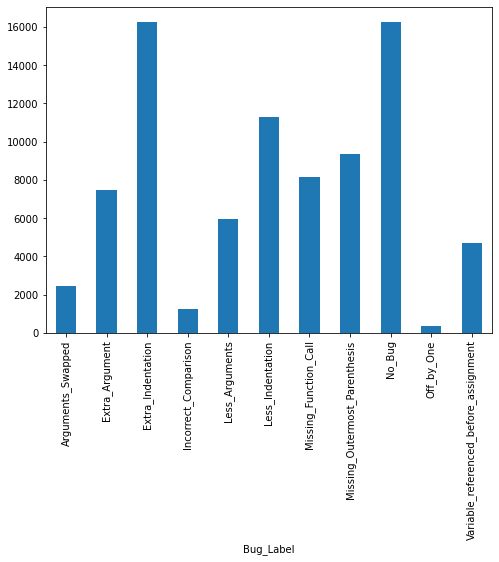

{0: 'No_Bug', 1: 'Extra_Indentation', 2: 'Extra_Argument', 3: 'Less_Arguments', 4: 'Variable_referenced_before_assignment', 5: 'Missing_Outermost_Parenthesis', 6: 'Missing_Function_Call', 7: 'Arguments_Swapped', 8: 'Less_Indentation', 9: 'Incorrect_Comparison', 10: 'Off_by_One'}


In [57]:
fig = plt.figure(figsize=(8,6))
df.groupby('Bug_Label').Line_of_Code.count().plot.bar(ylim=0)
plt.show()
print(bug_id_to_category)

# Vectorizing entire Training Dataset for Cross Validation

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.Line_of_Code).toarray()
labels = df.bug_category_id
features.shape

(83524, 21516)

# Creating a Training and Validation Split

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X_train, X_test, y_train, y_test = train_test_split(df['Line_of_Code'], df['bug_category_id'], random_state = 0)

# Using TFIDF Vectorizer for its elevated functionality over CountVectorizer
vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
# vect = CountVectorizer()

X_train_counts = vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)



# Checking Validity of Data Before Running it on Multiple ML Models Simultaneously

In [60]:
# print (X_train_tfidf.shape)
# print (type(X_train_tfidf))
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB().fit(X_train_tfidf, y_train)
# print((clf.predict(vect.fit_transform(["for y in range( end_year, begin_year):"]))))

print(X_train_tfidf.shape)
y_test = y_test.to_numpy()
X_test = vect.transform(X_test)

(62643, 16084)


# Evaluating Performance on Single Classifier Models

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    # SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=50),
    # MLPClassifier(alpha=1, max_iter=100),
    KNeighborsClassifier(n_neighbors=11)]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
# y_test = y_test.to_numpy()
# X_test = vect.transform(X_test)
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  clf = model.fit(X_train_tfidf, y_train)
  y_pred = (clf.predict(X_test))
  print (model_name)
  print (accuracy_score(y_test, y_pred))
  print (classification_report(y_test, y_pred))
  print("\n")
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



LinearSVC
0.19319754795333202
              precision    recall  f1-score   support

           0       0.09      0.12      0.11      1024
           1       0.08      0.08      0.08      1062
           2       0.26      0.16      0.20       408
           3       0.41      0.47      0.44       299
           4       0.00      0.00      0.00       276
           5       0.30      0.33      0.32       498
           6       0.51      0.63      0.57       468
           7       0.38      0.35      0.36       124
           8       0.08      0.07      0.07       748
           9       0.06      0.05      0.06       117
          10       0.00      0.00      0.00        33

    accuracy                           0.19      5057
   macro avg       0.20      0.21      0.20      5057
weighted avg       0.18      0.19      0.19      5057



MultinomialNB
0.11983389361281392
              precision    recall  f1-score   support

           0       0.11      0.24      0.15      1024
           1

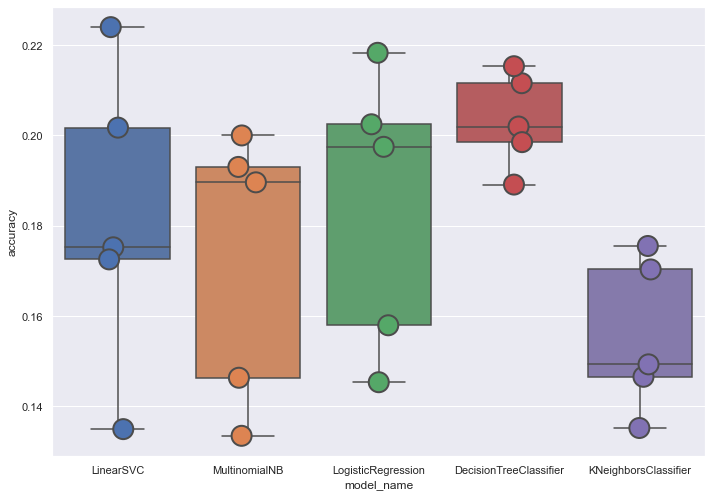

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=20, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# Comparing Performance of Best Single Classifier to Basic Ensemble Classifiers

In [26]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

models = [
    LinearSVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  clf = model.fit(X_train_tfidf, y_train)
  y_pred = (clf.predict(X_test))
  print (model_name)
  print (accuracy_score(y_test, y_pred))
  print (classification_report(y_test, y_pred))
  print("\n")
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


LinearSVC
0.19319754795333202
              precision    recall  f1-score   support

           0       0.09      0.12      0.11      1024
           1       0.08      0.08      0.08      1062
           2       0.26      0.16      0.20       408
           3       0.41      0.47      0.44       299
           4       0.00      0.00      0.00       276
           5       0.30      0.33      0.32       498
           6       0.51      0.63      0.57       468
           7       0.38      0.35      0.36       124
           8       0.08      0.07      0.07       748
           9       0.06      0.05      0.06       117
          10       0.00      0.00      0.00        33

    accuracy                           0.19      5057
   macro avg       0.20      0.21      0.20      5057
weighted avg       0.18      0.19      0.19      5057



RandomForestClassifier
0.19715246193395294
              precision    recall  f1-score   support

           0       0.11      0.14      0.12      1024
   

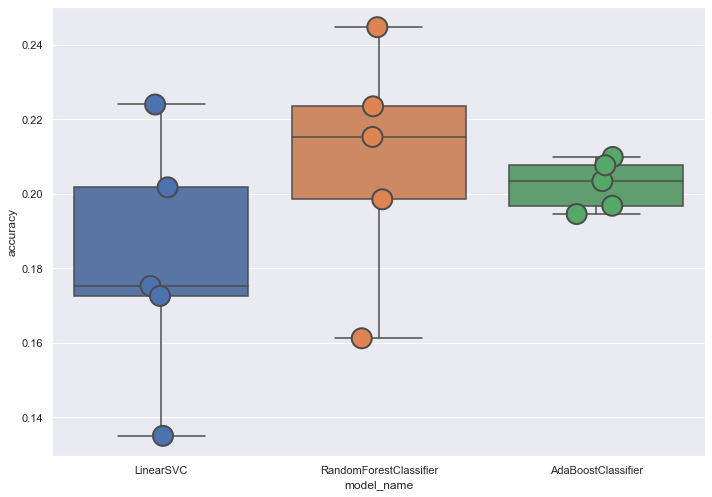

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=20, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# Evaluating Performance of Various Ensemble Classifiers with Change in Number of Base Estimators

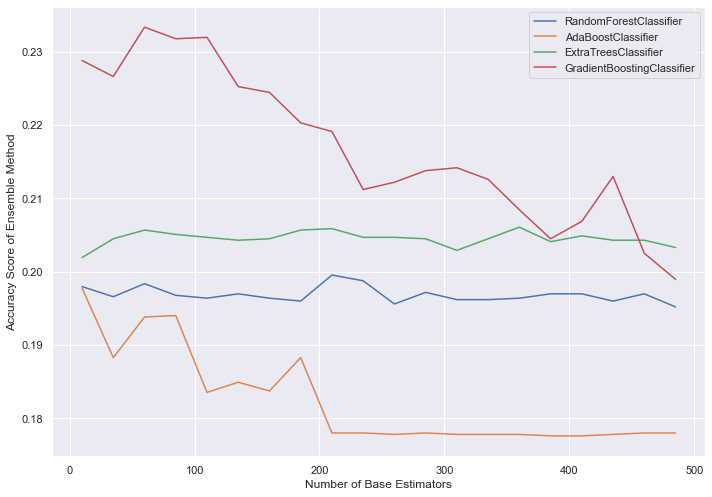

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

dictionary_accuracies = {'RandomForestClassifier': [], 'AdaBoostClassifier': [], 'ExtraTreesClassifier': [], 'GradientBoostingClassifier': []}
num_estimators = []
for estimators in range(10, 500, 25):
    num_estimators.append(estimators)
    models = [
    RandomForestClassifier(n_estimators=estimators),
    AdaBoostClassifier(n_estimators=estimators),
    ExtraTreesClassifier(n_estimators=estimators, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=estimators)
    ]
    for model in models:
        model_name = model.__class__.__name__
        clf = model.fit(X_train_tfidf, y_train)
        y_pred = (clf.predict(X_test))
        acc = (accuracy_score(y_test, y_pred))
        (dictionary_accuracies[model_name]).append(acc)

plt.clf()
for method in dictionary_accuracies:
    plt.plot(num_estimators, dictionary_accuracies[method], label = method)

plt.xlabel('Number of Base Estimators')
plt.ylabel('Accuracy Score of Ensemble Method')
plt.legend()
plt.show()

# Comparing Performance of Ensemble Models Accounting for the Optimal Number of Estimators

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = MultinomialNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

models = [
    RandomForestClassifier(max_depth=20, n_estimators=250, max_features=1),
    bagging,
    AdaBoostClassifier(),
    ExtraTreesClassifier(n_estimators=250, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0),
    eclf
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  clf = model.fit(X_train_tfidf, y_train)
  y_pred = (clf.predict(X_test))
  print (model_name)
  print (accuracy_score(y_test, y_pred))
  print (classification_report(y_test, y_pred))
  print("\n")
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
0.11920529801324503
              precision    recall  f1-score   support

           0       0.02      0.01      0.01       159
           1       0.13      0.59      0.22       146
           2       0.00      0.00      0.00        81
           3       1.00      0.02      0.03        60
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        84
           6       1.00      0.01      0.03        67
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        78
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         7

    accuracy                           0.12       755
   macro avg       0.20      0.06      0.03       755
weighted avg       0.20      0.12      0.05       755



/Users/andybirla/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-

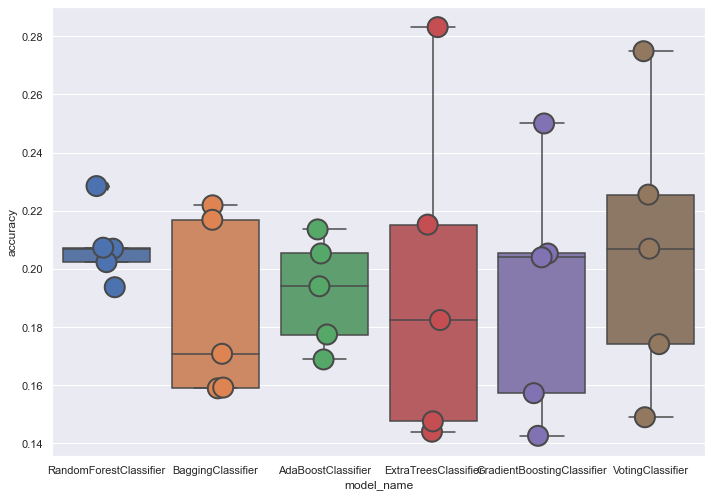

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=20, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# Using Keras AutoTuner to Search for the Best Parameters of the Best Classifier

# Installing and Importing Keras AutoTuner

In [9]:
!pip3 install -U keras-tuner

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [33]:
import kerastuner as kt

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

def build_model(hp):
    model_type = hp.Choice('model_type', ['extra_trees', 'gradboost'])
    max_features = hp.Choice('max_features', [1, 2, 3])
    if (max_features==1):
        max_f = 'auto'
    elif (max_features==2):
        max_f = 'log2'
    else:
        max_f = None
    if model_type == 'extra_trees':
        with hp.conditional_scope('model_type', 'extra_trees'):
            model = ExtraTreesClassifier(
                n_estimators=hp.Int('n_estimators', 10, 125, step=5),
                max_depth=hp.Int('max_depth', 3, 20, step=2),
                n_jobs = -1,
                max_features=max_f)
    elif model_type == 'gradboost':
        with hp.conditional_scope('model_type', 'gradboost'):
            model = GradientBoostingClassifier(
                subsample=hp.Choice('subsample', [.5, .6, .7, .8, .9, 1.0]),
                n_estimators=hp.Int('n_estimators_2', 10, 125, step=5),
                learning_rate=hp.Float('learning_rate', 1e-3, 1, sampling='log'))
    else:
        raise ValueError('Unrecognized model_type')
    return model

tuner = kt.tuners.Sklearn(
        oracle=kt.oracles.BayesianOptimization(
            objective=kt.Objective('score', 'max'),
            max_trials=10),
        hypermodel=build_model,
        directory='tmp_dir')

tuner.search(features, labels)

Trial 10 Complete [00h 22m 47s]
score: 0.19050815680448693

Best score So Far: 0.2032660981199827
Total elapsed time: 00h 55m 13s
INFO:tensorflow:Oracle triggered exit


# Testing Same Input Pipeline and Vectorization as above with a Simple Tensorflow Neural Network

In [61]:
df = pd.read_csv('demo_file_mini_projects_1.csv', delimiter = '%@!')
df.head()
df.shape

<ipython-input-61-87556195d9f0>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('demo_file_mini_projects_1.csv', delimiter = '%@!')


(83525, 2)

In [62]:
df = df[pd.notnull(df['Line_of_Code'])]
df.columns = ['Line_of_Code', 'Bug_Label']

df['bug_category_id'] = df['Bug_Label'].factorize()[0]
bug_category_id_df = df[['Bug_Label', 'bug_category_id']].drop_duplicates().sort_values('bug_category_id')
bug_category_to_id = dict(bug_category_id_df.values)
bug_id_to_category = dict(bug_category_id_df[['bug_category_id', 'Bug_Label']].values)
df.head()

,Line_of_Code,Bug_Label,bug_category_id
0,import random,No_Bug,0
1,import random,Extra_Indentation,1
2,import matplotlib.pyplot as plt,No_Bug,0
3,import matplotlib.pyplot as plt,Extra_Indentation,1
4,"doors = [""goat"",""goat"",""car""]",No_Bug,0


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.Line_of_Code).toarray()
labels = df.bug_category_id
features.shape

(83524, 21516)

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Line_of_Code'], df['bug_category_id'], random_state = 0)
vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2)) #CountVectorizer()
# vect = CountVectorizer()
X_train_counts = vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# print (X_train_tfidf.shape)
# print (type(X_train_tfidf))
# clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [65]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [66]:
from tensorflow.keras.layers import Dense 
from tensorflow.keras import Model

In [67]:
model_1c = tf.keras.models.Sequential([
  # added multiple dense layers
  tf.keras.layers.Dense(1000, activation='relu', name="dense2"),
  tf.keras.layers.Dense(500, activation='relu', name="dense3"),
  tf.keras.layers.Dense(100, activation='relu', name="dense4"),
  tf.keras.layers.Dense(11, activation='softmax', name="output")
])

model_1c.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
print (X_train_tfidf.shape)
print (type(X_train_tfidf))
print (y_train.shape)
print (type(y_train))

# print (X_test_tfidf.shape)
# print (type(X_train_tfidf))
print (y_test.shape)
print (type(y_test))

X_train_tfidf_numpy = X_train_tfidf.toarray()
X_test_tfidf_numpy = (vect.transform(X_test)).toarray()
y_train_numpy = y_train.to_numpy()
y_test_numpy = y_test #.to_numpy()
print (X_train_tfidf_numpy.shape)
print (type(X_train_tfidf_numpy))
print (y_train_numpy.shape)
print (type(y_train_numpy))

(62643, 16084)
<class 'scipy.sparse.csr.csr_matrix'>
(62643,)
<class 'pandas.core.series.Series'>
(20881,)
<class 'pandas.core.series.Series'>
(62643, 16084)
<class 'numpy.ndarray'>
(62643,)
<class 'numpy.ndarray'>


In [69]:
history = model_1c.fit(X_train_tfidf_numpy, y_train_numpy, validation_data=(X_test_tfidf_numpy, y_test_numpy), epochs=10)

Epoch 1/10
1958/1958 [==============================] - 181s 92ms/step - loss: 1.9953 - accuracy: 0.2341 - val_loss: 1.7197 - val_accuracy: 0.2953
Epoch 2/10
1958/1958 [==============================] - 178s 91ms/step - loss: 1.5552 - accuracy: 0.3375 - val_loss: 1.6614 - val_accuracy: 0.3102
Epoch 3/10
1958/1958 [==============================] - 173s 88ms/step - loss: 1.3858 - accuracy: 0.3770 - val_loss: 1.6921 - val_accuracy: 0.3184
Epoch 4/10
1958/1958 [==============================] - 176s 90ms/step - loss: 1.2943 - accuracy: 0.3968 - val_loss: 1.7651 - val_accuracy: 0.3235
Epoch 5/10
1958/1958 [==============================] - 170s 87ms/step - loss: 1.2394 - accuracy: 0.4093 - val_loss: 1.8294 - val_accuracy: 0.2940
Epoch 6/10
1958/1958 [==============================] - 174s 89ms/step - loss: 1.2024 - accuracy: 0.4234 - val_loss: 1.8934 - val_accuracy: 0.3082
Epoch 7/10
1958/1958 [==============================] - 175s 90ms/step - loss: 1.1778 - accuracy: 0.4316 - val_loss: 1

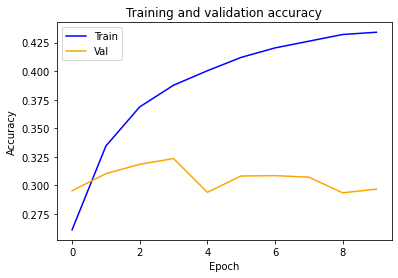

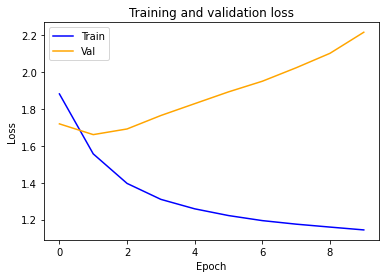

In [70]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)